# Lab | Making predictions with logistic regression

In [126]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy import stats
password = getpass.getpass()

········


### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [127]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
        select f.film_id, f.title as film_title, f.rental_duration, f.rental_rate, r.rental_id, r.rental_date, r.return_date
        from film f
        join inventory i
        on f.film_id = i.inventory_id
        join rental r
        on i.inventory_id = r.inventory_id
        
        '''

# 2- Read the data into a Pandas dataframe

data = pd.read_sql_query(query, engine)
data

,film_id,film_title,rental_duration,rental_rate,rental_id,rental_date,return_date
0,1,ACADEMY DINOSAUR,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15
1,1,ACADEMY DINOSAUR,6,0.99,11433,2005-08-02 20:13:10,2005-08-11 21:35:10
2,1,ACADEMY DINOSAUR,6,0.99,14714,2005-08-21 21:27:43,2005-08-30 22:26:43
3,1,ACADEMY DINOSAUR,6,0.99,16050,2021-06-25 18:15:37,NaT
4,2,ACE GOLDFINGER,3,4.99,972,2005-05-30 20:21:07,2005-06-06 00:36:07
...,...,...,...,...,...,...,...
3471,999,ZOOLANDER FICTION,5,2.99,12319,2005-08-18 06:26:45,2005-08-23 01:35:45
3472,1000,ZORRO ARK,3,4.99,1235,2005-06-15 04:31:28,2005-06-22 10:08:28
3473,1000,ZORRO ARK,3,4.99,5987,2005-07-11 00:55:31,2005-07-16 06:28:31
3474,1000,ZORRO ARK,3,4.99,8441,2005-07-29 07:33:05,2005-08-04 04:00:05


###  3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

#### Checking the data

In [128]:
data.dtypes

film_id                     int64
film_title                 object
rental_duration             int64
rental_rate               float64
rental_id                   int64
rental_date        datetime64[ns]
return_date        datetime64[ns]
dtype: object

In [129]:
data.describe()

,film_id,rental_duration,rental_rate,rental_id
count,3476.000000,3476.000000,3476.000000,3476.000000
mean,497.616801,4.997411,2.952601,8076.105006
std,286.334389,1.417362,1.655785,4638.498521
min,1.000000,3.000000,0.990000,1.000000
25%,246.000000,4.000000,0.990000,4119.500000
50%,495.000000,5.000000,2.990000,8080.000000
75%,743.000000,6.000000,4.990000,12078.250000
max,1000.000000,7.000000,4.990000,16050.000000


In [130]:
data.isnull().sum()

film_id             0
film_title          0
rental_duration     0
rental_rate         0
rental_id           0
rental_date         0
return_date        46
dtype: int64

In [131]:
data = data.dropna()

### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [132]:
query1 = '''
        with cte as (
            SELECT f.film_id,
            date_format(convert(r.rental_date,date),'%m') as actual_rental_date,
            CASE WHEN lag(r.rental_date) OVER() THEN TRUE ELSE FALSE END as rented_last_month
        FROM film f
        JOIN inventory i 
        ON f.film_id = i.inventory_id
        JOIN rental r
        ON i.inventory_id = r.inventory_id
        ORDER BY 1
        )
        SELECT *
        FROM cte;
        '''

In [133]:
data1 = pd.read_sql_query(query1, engine)
data1

,film_id,actual_rental_date,rented_last_month
0,1,07,0
1,1,08,1
2,1,08,1
3,1,06,1
4,2,05,1
...,...,...,...
3471,999,08,1
3472,1000,06,1
3473,1000,07,1
3474,1000,07,1


In [134]:
data2 = pd.merge(data, data1[["film_id", "actual_rental_date", "rented_last_month"]], on= "film_id", how="left")

In [135]:
data2

,film_id,film_title,rental_duration,rental_rate,rental_id,rental_date,return_date,actual_rental_date,rented_last_month
0,1,ACADEMY DINOSAUR,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,07,0
1,1,ACADEMY DINOSAUR,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,08,1
2,1,ACADEMY DINOSAUR,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,08,1
3,1,ACADEMY DINOSAUR,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,06,1
4,1,ACADEMY DINOSAUR,6,0.99,11433,2005-08-02 20:13:10,2005-08-11 21:35:10,07,0
...,...,...,...,...,...,...,...,...,...
13173,1000,ZORRO ARK,3,4.99,8441,2005-07-29 07:33:05,2005-08-04 04:00:05,08,1
13174,1000,ZORRO ARK,3,4.99,15200,2005-08-22 16:22:53,2005-08-24 10:25:53,06,1
13175,1000,ZORRO ARK,3,4.99,15200,2005-08-22 16:22:53,2005-08-24 10:25:53,07,1
13176,1000,ZORRO ARK,3,4.99,15200,2005-08-22 16:22:53,2005-08-24 10:25:53,07,1


In [136]:
data2['rented_last_month'] = data2['rented_last_month'].astype(str)

In [137]:
for col in data2.select_dtypes('object'):
    print(data2[col].value_counts(), '\n')


RAIDERS ANTITRUST     25
WHALE BIKINI          25
LOST BIRD             25
CIDER DESIRE          25
FORWARD TEMPLE        25
                      ..
RIVER OUTLAW           2
POTTER CONNECTICUT     2
UNITED PILOT           2
ALABAMA DEVIL          2
CALENDAR GUNFIGHT      2
Name: film_title, Length: 999, dtype: int64 

07    5344
08    4343
06    2179
05    1219
02      93
Name: actual_rental_date, dtype: int64 

1    13175
0        3
Name: rented_last_month, dtype: int64 



#### EDA

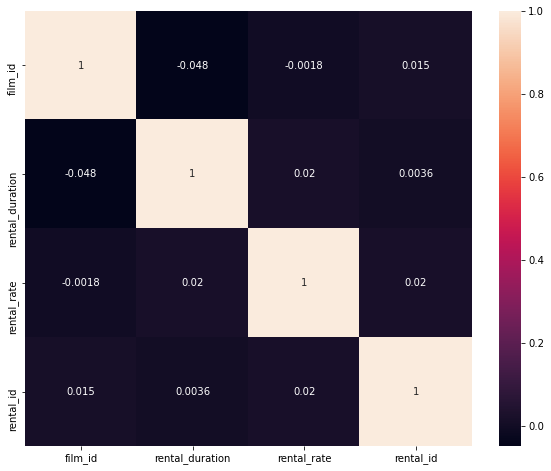

In [138]:

corr_matrix=data2.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()



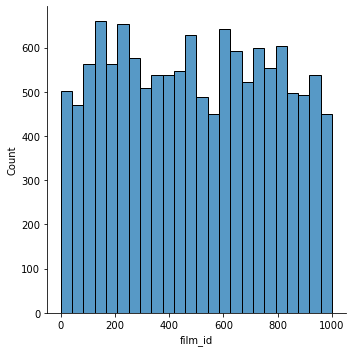

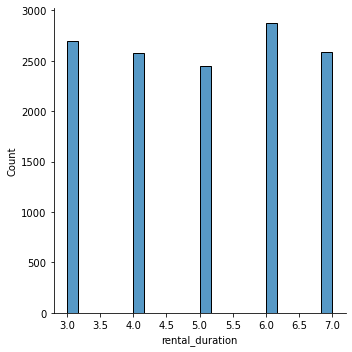

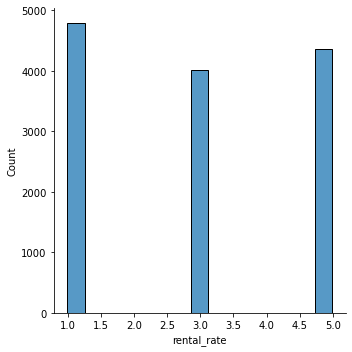

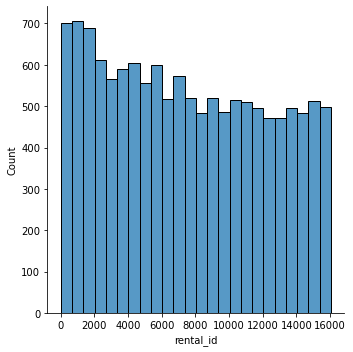

In [139]:
for col in data2.select_dtypes(np.number):
    sns.displot(data2[col])
    plt.show()

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [140]:
y = data2['rented_last_month']
X = data2.drop(['rented_last_month'], axis=1)

In [141]:
X = pd.get_dummies(X)
X

,film_id,rental_duration,rental_rate,rental_id,rental_date,return_date,film_title_ACADEMY DINOSAUR,film_title_ACE GOLDFINGER,film_title_ADAPTATION HOLES,film_title_AFFAIR PREJUDICE,...,film_title_YOUNG LANGUAGE,film_title_YOUTH KICK,film_title_ZHIVAGO CORE,film_title_ZOOLANDER FICTION,film_title_ZORRO ARK,actual_rental_date_02,actual_rental_date_05,actual_rental_date_06,actual_rental_date_07,actual_rental_date_08
0,1,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,6,0.99,4863,2005-07-08 19:03:15,2005-07-11 21:29:15,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,6,0.99,11433,2005-08-02 20:13:10,2005-08-11 21:35:10,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13173,1000,3,4.99,8441,2005-07-29 07:33:05,2005-08-04 04:00:05,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
13174,1000,3,4.99,15200,2005-08-22 16:22:53,2005-08-24 10:25:53,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
13175,1000,3,4.99,15200,2005-08-22 16:22:53,2005-08-24 10:25:53,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
13176,1000,3,4.99,15200,2005-08-22 16:22:53,2005-08-24 10:25:53,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=500) # max_iter
classification.fit(X_train, y_train)

TypeError: invalid type promotion

In [ ]:
#Cannot pass through this error